In [18]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

# Đặt seed để đảm bảo kết quả ổn định
np.random.seed(42)

In [19]:
#Tải dữ liệu
def load_json_dataset(folder_path, return_video_ids=False):
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Thư mục '{folder_path}' không tồn tại.")
    
    data, labels, video_ids = [], [], []
    label_to_idx = {}
    idx = 0
    
    for pose_folder in os.listdir(folder_path):
        pose_path = os.path.join(folder_path, pose_folder)
        if not os.path.isdir(pose_path):
            continue
        for video_folder in os.listdir(pose_path):
            video_path = os.path.join(pose_path, video_folder)
            if not os.path.isdir(video_path):
                continue
            for filename in os.listdir(video_path):
                if filename.endswith('.json'):
                    try:
                        with open(os.path.join(video_path, filename), 'r') as f:
                            json_data = json.load(f)
                            for _, info in json_data.items():
                                if 'features' not in info or 'label' not in info:
                                    continue
                                data.append(info['features'])
                                label = info['label']
                                if label not in label_to_idx:
                                    label_to_idx[label] = idx
                                    idx += 1
                                labels.append(label_to_idx[label])
                                video_ids.append(video_folder)
                    except json.JSONDecodeError:
                        continue
    
    if not data:
        raise ValueError("Không tìm thấy dữ liệu hợp lệ.")
    
    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int64)
    video_ids = np.array(video_ids)
    
    if return_video_ids:
        return data, labels, label_to_idx, video_ids
    return data, labels, label_to_idx

In [20]:
#Tăng cường dữ liệu keypoints với nhiễu, xoay, và thay đổi tỷ lệ   
def augment_keypoints(data, noise_scale=0.05, rotation_angle=20, scale_range=(0.9, 1.1), num_augmented=3):
    augmented = []
    for _ in range(num_augmented):
        noise = np.random.normal(0, noise_scale, data.shape)
        aug_data = data + noise
        
        angle = np.random.uniform(-rotation_angle, rotation_angle)
        theta = np.radians(angle)
        rot_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        for i in range(0, aug_data.shape[1], 2):
            aug_data[:, i:i+2] = aug_data[:, i:i+2] @ rot_matrix
        
        scale = np.random.uniform(scale_range[0], scale_range[1])
        aug_data *= scale
        augmented.append(aug_data)
    return np.vstack(augmented) if augmented else data

def dropout(X, drop_prob):
    mask = np.random.binomial(1, 1 - drop_prob, size=X.shape) / (1 - drop_prob)
    return X * mask

def one_hot(y, num_classes):
    onehot = np.zeros((len(y), num_classes))
    onehot[np.arange(len(y)), y] = 1
    return onehot

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy(y_pred, y_true, weights, l2_lambda):
    ce_loss = -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))
    l2_loss = 0.5 * l2_lambda * sum(np.sum(w**2) for w in weights)
    return ce_loss + l2_loss

class MLP:
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size, l2_lambda=0.000001):
        self.W1 = np.random.randn(input_size, hidden1_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden1_size))
        self.W2 = np.random.randn(hidden1_size, hidden2_size) * np.sqrt(2.0 / hidden1_size)
        self.b2 = np.zeros((1, hidden2_size))
        self.W3 = np.random.randn(hidden2_size, output_size) * np.sqrt(2.0 / hidden2_size)
        self.b3 = np.zeros((1, output_size))
        self.l2_lambda = l2_lambda
    
    #Lan truyền xuôi qua mạng
    def forward(self, X, drop_prob=0.0, training=True):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = dropout(relu(self.z1), drop_prob) if training else relu(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = dropout(relu(self.z2), drop_prob) if training else relu(self.z2)
        self.z3 = self.a2 @ self.W3 + self.b3
        return softmax(self.z3)
        
    #Lan truyền ngược với cắt tỉa gradient
    def backward(self, X, y_true, y_pred, lr, max_grad_norm):
        dz3 = y_pred - y_true
        dW3 = self.a2.T @ dz3
        db3 = np.sum(dz3, axis=0, keepdims=True)
        
        da2 = dz3 @ self.W3.T
        dz2 = da2 * (self.z2 > 0)
        dW2 = self.a1.T @ dz2
        db2 = np.sum(dz2, axis=0, keepdims=True)
        
        da1 = dz2 @ self.W2.T
        dz1 = da1 * (self.z1 > 0)
        dW1 = X.T @ dz1
        db1 = np.sum(dz1, axis=0, keepdims=True)
        
        for grad in [dW1, dW2, dW3, db1, db2, db3]:
            norm = np.linalg.norm(grad)
            if norm > max_grad_norm:
                grad *= max_grad_norm / (norm + 1e-9)
        
        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W3 -= lr * dW3
        self.b3 -= lr * db3
        
        return [self.W1, self.W2, self.W3]

In [21]:
# Đường dẫn dữ liệu
train_folder = r'processed_data\results_posekeypoints_mlp\step5'
test_folder = r'processed_data\Pose keypoints + MLP\step5'

# Tải dữ liệu huấn luyện
try:
    X_train_full, y_train_full, label_to_idx, video_ids = load_json_dataset(train_folder, return_video_ids=True)
    print(f"Kích thước train: {X_train_full.shape}, Nhãn: {y_train_full.shape}")
except Exception as e:
    print(f"Lỗi khi tải dữ liệu huấn luyện: {e}")
    raise

# Tải dữ liệu kiểm tra
try:
    X_test, y_test, label_to_idx_test = load_json_dataset(test_folder)
    print(f"Kích thước test: {X_test.shape}, Nhãn: {y_test.shape}")
    unique, counts = np.unique(y_test, return_counts=True)
    print("Phân bố nhãn test:", dict(zip(label_to_idx.keys(), counts)))
except Exception as e:
    print(f"Lỗi khi tải dữ liệu kiểm tra: {e}")
    raise

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

# Chia dữ liệu thành tập huấn luyện và xác thực theo video
unique_videos = np.unique(video_ids)
video_labels = [y_train_full[np.where(video_ids == vid)[0][0]] for vid in unique_videos]
train_videos, val_videos = train_test_split(unique_videos, test_size=0.2, random_state=42, stratify=video_labels)
train_mask = np.isin(video_ids, train_videos)
val_mask = np.isin(video_ids, val_videos)
X_train = X_train_full[train_mask]
y_train = y_train_full[train_mask]
X_val = X_train_full[val_mask]
y_val = y_train_full[val_mask]
train_video_ids = video_ids[train_mask]
val_video_ids = video_ids[val_mask]

# Tăng cường dữ liệu
if True:
    X_train = np.vstack([X_train, augment_keypoints(X_train, num_augmented=3)])
    y_train = np.concatenate([y_train, np.tile(y_train, 3)])
    train_video_ids = np.concatenate([train_video_ids, np.tile(train_video_ids, 3)])
    print("\nĐã tăng cường dữ liệu.")

# Hiển thị kích thước và phân bố nhãn
print(f"\nTrain: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print("Phân bố nhãn train:", dict(zip(label_to_idx.keys(), np.unique(y_train, return_counts=True)[1])))
print("Phân bố nhãn val:", dict(zip(label_to_idx.keys(), np.unique(y_val, return_counts=True)[1])))
print("Phân bố nhãn test:", dict(zip(label_to_idx.keys(), np.unique(y_test, return_counts=True)[1])))

Kích thước train: (14643, 20), Nhãn: (14643,)
Kích thước test: (4152, 20), Nhãn: (4152,)
Phân bố nhãn test: {0: np.int64(831), 1: np.int64(807), 2: np.int64(852), 3: np.int64(792), 4: np.int64(870)}

Đã tăng cường dữ liệu.

Train: (45876, 20), Val: (3174, 20), Test: (4152, 20)
Phân bố nhãn train: {0: np.int64(8268), 1: np.int64(8712), 2: np.int64(9612), 3: np.int64(8700), 4: np.int64(10584)}
Phân bố nhãn val: {0: np.int64(708), 1: np.int64(603), 2: np.int64(741), 3: np.int64(525), 4: np.int64(597)}
Phân bố nhãn test: {0: np.int64(831), 1: np.int64(807), 2: np.int64(852), 3: np.int64(792), 4: np.int64(870)}


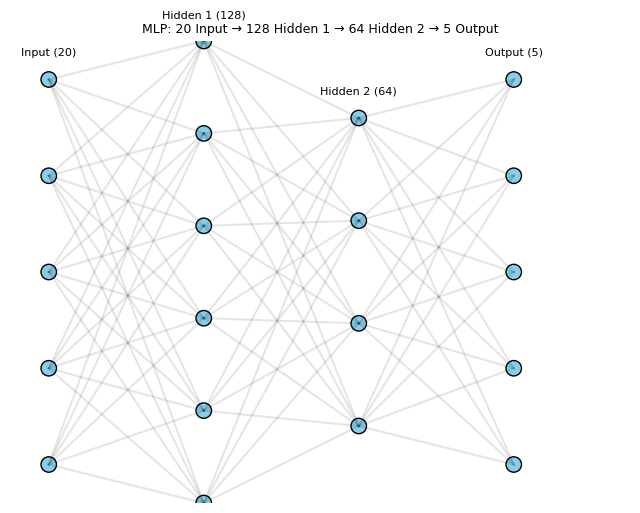

In [22]:
#Khởi tạo mô hình
input_size = X_train.shape[1] 
hidden1_size = 128
hidden2_size = 64
output_size = len(np.unique(y_train))
l2_lambda=0.0001
model = MLP(input_size, hidden1_size, hidden2_size, output_size, l2_lambda)

# Số nơ-ron hiển thị (giảm để rõ ràng) và nhãn
layers = [(5, "Input (20)"), (6, "Hidden 1 (128)"), (4, "Hidden 2 (64)"), (5, "Output (5)")]

plt.figure(figsize=(8, 6))
ax = plt.gca()

# Vẽ nơ-ron và kết nối
neuron_pos = []
for i, (display_size, label) in enumerate(layers):
    x = i * 2  # Khoảng cách ngang
    y_pos = np.linspace(-display_size / 2, display_size / 2, display_size)  # Tọa độ y
    neuron_pos.append([(x, y) for y in y_pos])
    # Vẽ nơ-ron
    for y in y_pos:
        ax.add_patch(plt.Circle((x, y), 0.1, color='skyblue', ec='black'))
    ax.text(x, display_size / 2 + 0.3, label, ha='center', fontsize=8)
    # Kết nối với tầng trước
    if i > 0:
        for x1, y1 in neuron_pos[i-1]:
            for x2, y2 in neuron_pos[i]:
                ax.plot([x1, x2], [y1, y2], 'k-', alpha=0.1)

# Tùy chỉnh
ax.set_xlim(-0.5, 7.5)
ax.set_ylim(-3, 3)
ax.axis('off')
plt.title("MLP: 20 Input → 128 Hidden 1 → 64 Hidden 2 → 5 Output", fontsize=9)
plt.show()


In [23]:
#Huấn luyện
# Mã hóa one-hot
y_train_oh = one_hot(y_train, output_size)
y_val_oh = one_hot(y_val, output_size)

# Siêu tham số
epochs = 300
lr = 0.001
drop_prob = 0.43
max_grad_norm = 50.0
early_stopping_patience = 25
min_delta = 0.01
batch_size = 128
num_batches = len(X_train) // batch_size

train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_acc = 0
best_epoch = 0
best_params = {}
epochs_no_improve = 0

# Vòng lặp huấn luyện
for epoch in range(epochs):
    indices = np.random.permutation(len(X_train))
    X_train_shuffled, y_train_oh_shuffled, y_train_labels_shuffled = X_train[indices], y_train_oh[indices], y_train[indices]
    
    epoch_loss = 0
    epoch_acc = 0
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        X_batch = X_train_shuffled[start_idx:end_idx]
        y_batch = y_train_oh_shuffled[start_idx:end_idx]
        y_batch_labels = y_train_labels_shuffled[start_idx:end_idx]
        
        y_pred = model.forward(X_batch, drop_prob)
        loss = cross_entropy(y_pred, y_batch, [model.W1, model.W2, model.W3], model.l2_lambda)
        acc = np.mean(np.argmax(y_pred, axis=1) == y_batch_labels)
        model.backward(X_batch, y_batch, y_pred, lr, max_grad_norm)
        
        epoch_loss += loss
        epoch_acc += acc * len(X_batch)
    
    epoch_loss /= num_batches
    epoch_acc /= len(X_train)
    
    y_val_pred = model.forward(X_val, drop_prob=0.0)
    val_loss = cross_entropy(y_val_pred, y_val_oh, [model.W1, model.W2, model.W3], l2_lambda)
    val_acc = np.mean(np.argmax(y_val_pred, axis=1) == y_val)
    
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    train_accs.append(epoch_acc)
    val_accs.append(val_acc)
    
    if val_acc - best_val_acc > min_delta:
        best_val_acc = val_acc
        best_epoch = epoch
        best_params = {
            'W1': model.W1.copy(), 'b1': model.b1.copy(),
            'W2': model.W2.copy(), 'b2': model.b2.copy(),
            'W3': model.W3.copy(), 'b3': model.b3.copy()
        }
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == 15:
            lr *= 0.3
            print(f"\nGiảm learning rate xuống: {lr}")
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Train Loss = {epoch_loss:.2f}, Train acc = {epoch_acc:.2f} | Val Loss = {val_loss:.2f}, Val acc = {val_acc:.2f}")
        
    if epochs_no_improve >= early_stopping_patience:
        print(f"\nDừng sớm tại epoch {epoch}. Độ chính xác xác thực tốt nhất: {best_val_acc:.2f} tại epoch {best_epoch}")
        break

# Khôi phục tham số tốt nhất
model.W1, model.b1 = best_params['W1'], best_params['b1']
model.W2, model.b2 = best_params['W2'], best_params['b2']
model.W3, model.b3 = best_params['W3'], best_params['b3']

Epoch 0: Train Loss = 1.50, Train acc = 0.43 | Val Loss = 1.08, Val acc = 0.67
Epoch 5: Train Loss = 0.93, Train acc = 0.67 | Val Loss = 0.85, Val acc = 0.74
Epoch 10: Train Loss = 0.86, Train acc = 0.72 | Val Loss = 1.05, Val acc = 0.72
Epoch 15: Train Loss = 0.84, Train acc = 0.74 | Val Loss = 0.99, Val acc = 0.74
Epoch 20: Train Loss = 0.84, Train acc = 0.76 | Val Loss = 0.91, Val acc = 0.76
Epoch 25: Train Loss = 0.86, Train acc = 0.77 | Val Loss = 0.97, Val acc = 0.77
Epoch 30: Train Loss = 0.89, Train acc = 0.77 | Val Loss = 1.33, Val acc = 0.70

Giảm learning rate xuống: 0.0003
Epoch 35: Train Loss = 0.75, Train acc = 0.80 | Val Loss = 1.05, Val acc = 0.75
Epoch 40: Train Loss = 0.77, Train acc = 0.79 | Val Loss = 0.97, Val acc = 0.76
Epoch 45: Train Loss = 0.80, Train acc = 0.79 | Val Loss = 1.01, Val acc = 0.75
Epoch 50: Train Loss = 0.81, Train acc = 0.78 | Val Loss = 1.01, Val acc = 0.75

Giảm learning rate xuống: 8.999999999999999e-05
Epoch 55: Train Loss = 0.77, Train acc 

In [24]:
y_test_pred = model.forward(X_test, drop_prob=0.0)
test_acc = (np.argmax(y_test_pred, axis=1)==y_test).mean()

print(f"Độ chính xác trên tập kiểm tra: {test_acc:.2f}")

Độ chính xác trên tập kiểm tra: 0.75


In [25]:
# Dự đoán và đánh giá trên test
y_test_pred = model.forward(X_test, drop_prob=0.0)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

print("=== Đánh giá trên Tập Test ===")
print(classification_report(y_test, y_test_pred_labels))

=== Đánh giá trên Tập Test ===
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       831
           1       0.71      0.95      0.81       807
           2       0.65      0.77      0.71       852
           3       0.80      0.65      0.72       792
           4       0.84      0.56      0.67       870

    accuracy                           0.75      4152
   macro avg       0.77      0.76      0.75      4152
weighted avg       0.77      0.75      0.75      4152



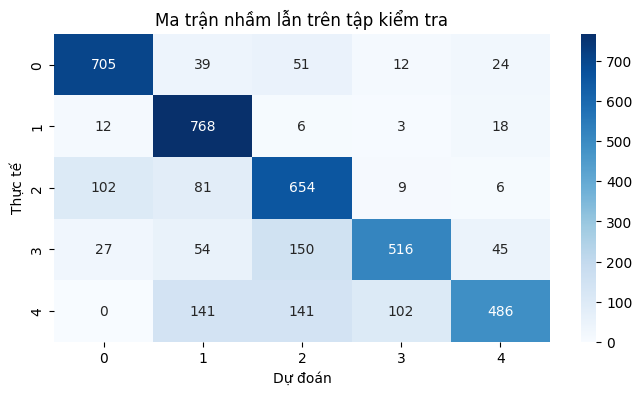

In [26]:
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
cm = confusion_matrix(y_test, y_test_pred_labels)
plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()))
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn trên tập kiểm tra')
plt.show()

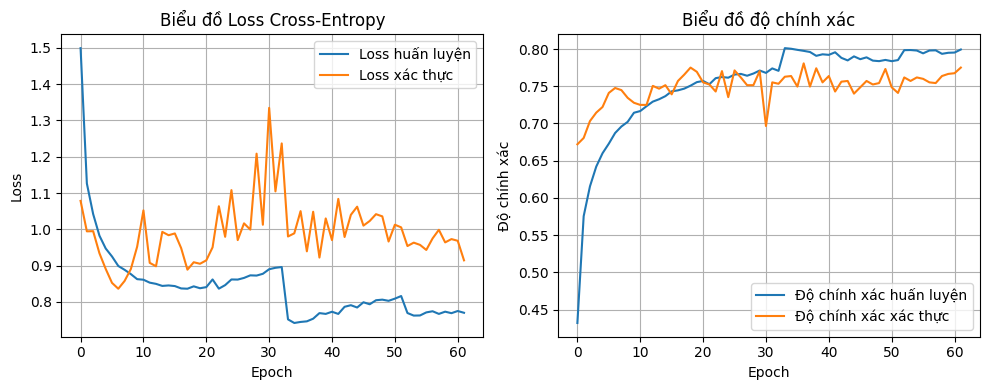

In [27]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss huấn luyện')
plt.plot(val_losses, label='Loss xác thực')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Biểu đồ Loss Cross-Entropy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)

plt.plot(train_accs, label='Độ chính xác huấn luyện')
plt.plot(val_accs, label='Độ chính xác xác thực')
plt.xlabel('Epoch')
plt.ylabel('Độ chính xác')
plt.title('Biểu đồ độ chính xác')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()